In [1]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
from skimage import data, util, transform
from skimage.transform import AffineTransform
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')
rc('image', cmap='gray', interpolation='nearest')


In [2]:
%matplotlib inline

In [3]:
edge = 10
size = 128
crop = np.s_[edge:(edge+size),edge:(edge+size)]

def blob():
    mask = data.binary_blobs(length=size+2*edge, blob_size_fraction=0.07, volume_fraction=.25, seed=1)
    image = np.random.normal(loc = .7, scale=.003, size=mask.shape)
    image[np.invert(mask)] = .3
    return image

In [4]:
pad = np.zeros((2*size+1, 2*size+1), np.float32)
def create_window():
    hann = scipy.signal.hanning(size)
    window = np.zeros_like(pad)
    window[:size,:size] = np.sqrt(np.outer(hann, hann))
    return window

In [5]:
class randow_walk:
    def __init__(self, image, length=9999999):
        self.image = image
        self.length = length
        self.walk = [(0,0)]
        
    def __iter__(self):
        return self
    
    def __next__(self):
        self.walk.append(self.walk[-1] + np.random.choice(np.arange(-3,3,.1), size=2))
        xform = AffineTransform(translation = self.walk[-1])
        capture = transform.warp(image, xform)
        capture = util.random_noise(capture, var=.0001)
        
        if len(self.walk) > self.length:
            raise StopIteration()
            
        return capture[crop]

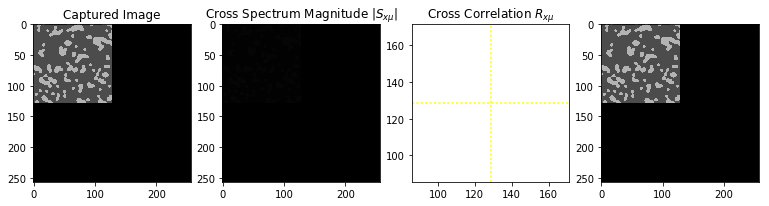

In [121]:
window = create_window()
image = blob()
np.random.seed(10)

def frequency(image):
    return np.fft.fftshift(np.log(np.abs(np.fft.fft2(window*image))))

class MotionModel:
    def __init__(self, image):
        self.image = image
        self.walk = [(0,0)]
        
    def __iter__(self):
        return self
    
    def __next__(self):
        xform = AffineTransform(translation = self.walk[-1])
        capture = transform.warp(image, xform)
        capture = util.random_noise(capture, var=.0001)
        return capture[crop]

class HorizontalDrift(MotionModel):
    def __next__(self):
        self.walk.append(self.walk[-1] + np.array([1,0]))
        return MotionModel.__next__(self)

class VerticalDrift(MotionModel):
    def __next__(self):
        self.walk.append(self.walk[-1] + np.array([0,1]))
        return MotionModel.__next__(self)

class RandomWalk(MotionModel):
    def __next__(self):
        self.walk.append(self.walk[-1] + np.random.choice(np.arange(-3,3,.1), size=2))
        return MotionModel.__next__(self)
    
def correction(image):
    capture = VerticalDrift(image)
    walklen = 16
    imagelist = [next(capture) for i in range(walklen)]
    mu_image = np.zeros_like(pad)
    frame = np.zeros_like(pad)
    for outer in range(3):
        mu_image[:size, :size] = sum(imagelist)/len(imagelist)
        mu_F = np.conjugate(np.fft.fft2(mu_image))
        for i, img in enumerate(imagelist):      
            frame[:size,:size] = img
            Sxm = np.fft.fft2(frame)*mu_F
            Rxm = np.fft.fftshift(np.absolute(np.fft.ifft2(Sxm/np.absolute(Sxm))))
            argmax = np.unravel_index(Rxm.argmax(), Rxm.shape)
            argmax = (argmax[1]-N/2+.5, argmax[0]-N/2+.5)
            print(argmax)
            reg = transform.warp(frame, AffineTransform(translation=argmax))
            imagelist[i] = reg[:size,:size]
            yield (frame, Sxm, Rxm, reg)

N = pad.shape[0]
pad[:size,:size] = image[crop]
fig, [ax1, ax2, ax3, ax4] = plt.subplots(ncols=4, nrows=1, figsize=(13,6))
im = ax1.imshow(pad, vmin=0, vmax=1)
ax1.set_title('Captured Image')

ax2.set_title('Cross Spectrum Magnitude $|S_{x\mu}|$')
im2 = ax2.imshow(pad, vmin=0, vmax=30)
im3 = ax3.imshow(pad, vmin=-10, vmax=0, zorder=0)
ax3.axis([N/2-N/6, N/2+N/6, N/2-N/6, N/2+N/6])
im4 = ax4.imshow(pad, vmin=0, vmax=1)

track, = ax3.plot([], [], color='cyan', lw=5, alpha=.5, zorder=2, animated=True)
truth, = ax3.plot(
    [],
    # [pad.shape[0]/2 - x[0] -.5 for x in model.walk], [pad.shape[1]/2 - x[1] -.5 for x in model.walk], 
    color='red', zorder=1, lw=10, alpha=.5)
vmark = ax3.axvline(N/2, color='yellow', linestyle=':', alpha=1)
hmark = ax3.axhline(N/2, color='yellow', linestyle=':', alpha=1)

ax3.set_title('Cross Correlation $R_{x\mu}$')

walk_x = []
walk_y = []
truth_x = []
truth_y = []

def animate(data):
    frame, Sxm, Rxm, reg = data
    
    im.set_array(frame)
    im2.set_array(np.fft.fftshift(np.log(np.absolute(Sxm))))
    im3.set_data(np.log(Rxm))
    im4.set_array(reg)
    argmax = np.unravel_index(Rxm.argmax(), Rxm.shape)
    hmark.set_ydata([argmax[0]])
    vmark.set_xdata([argmax[1]])
    walk_x.append(argmax[0])
    walk_y.append(argmax[1])
    track.set_data(walk_y, walk_x)
    return im, im2, im3, im4, hmark, vmark, track

In [122]:
anim = animation.FuncAnimation(fig, animate, frames=correction(image), blit=True)
anim

(0.0, 0.0)
(0.0, 0.0)
(0.0, -2.0)
(0.0, -3.0)
(0.0, -4.0)
(0.0, -5.0)
(0.0, -6.0)
(0.0, -7.0)
(0.0, -8.0)
(0.0, 6.0)
(0.0, 5.0)
(0.0, 4.0)
(0.0, 3.0)
(0.0, 2.0)
(0.0, 1.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, -1.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, -15.0)
(0.0, -15.0)
(0.0, -15.0)
(0.0, -15.0)
(0.0, -15.0)
(0.0, -15.0)
(0.0, -15.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
